# Predict WSB Sales using only Sales data






### Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

Using TensorFlow backend.


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
!ls -l 'drive/My Drive/AIML/SequentialModels'

total 1164
-rw------- 1 root root   2182 Apr 12 03:41  airline-passengers.csv
-rw------- 1 root root 183904 Apr 12 07:48 'google (1).csv'
-rw------- 1 root root  48231 Jun  1 16:35  Lab0_Word2vec_gensim_movie_data.ipynb
-rw------- 1 root root 215350 Jun  1 05:37 'Lab1_TimeSeries - Air Passengers Traffic.ipynb'
-rw------- 1 root root 186016 Apr 12 03:41  Lab2_stockPriceDirectionPrediction_v2.ipynb
-rw------- 1 root root   8544 Apr 12 03:41 'LSTM Sentiment Analysis Kaggle.ipynb'
-rw------- 1 root root 459888 Jun  1 05:54  Predict_Air_Passengers_Traffic_TS.ipynb
-rw------- 1 root root  77617 Jun  3 17:04  Predict_WSBSales_TS.ipynb
drwx------ 2 root root   4096 Jun  1 03:23  savedModels
-rw------- 1 root root   1763 Apr 12 07:48  Tractor-Sales.csv
-rw------- 1 root root    915 Apr 12 07:48  wsbSalesData.csv
-rw------- 1 root root    151 May 31 19:28  wsbSalesData.gsheet


In [6]:
df = pd.read_csv('/content/drive/My Drive/AIML/SequentialModels/wsbSalesData.csv')
df.sort_index(inplace=True)
df.shape

(48, 4)

In [7]:
df.head(4)

,Month,Sale Quantity,Promotion Expenses,Competition Promotion
0,1,3002666,105,1
1,2,4401553,145,0
2,3,3205279,118,1
3,4,4245349,130,0


In [8]:
df.tail(4)

,Month,Sale Quantity,Promotion Expenses,Competition Promotion
44,45,5162201,170,0
45,46,4627177,160,0
46,47,4623945,168,0
47,48,4599368,166,0


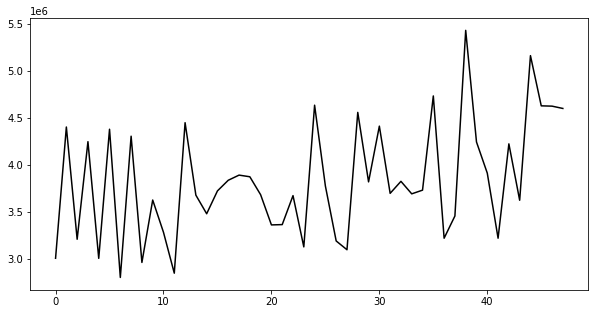

In [9]:
#Plot of complete dataset
ax = df['Sale Quantity'].plot(figsize=(10,5), color ='black')

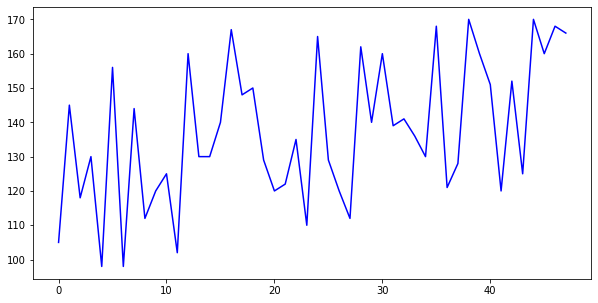

In [10]:
ax = df['Promotion Expenses'].plot(figsize=(10,5), color ='blue')

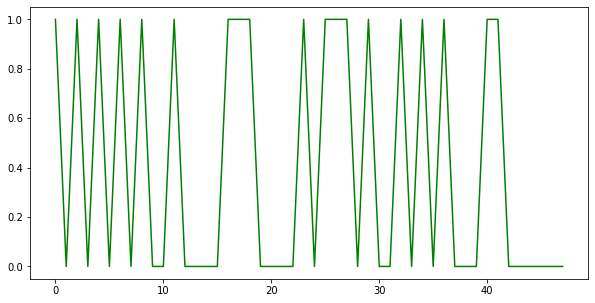

In [11]:
ax = df['Competition Promotion'].plot(figsize=(10,5), color ='green')


#### Observations:
- We do not see any pattern, trend or seasonality in the data for Sale Quantity and Promotion Expenses
- Since, Competition Promotion has only two values 0 and 1, there is known pattern in this feature


### Data Preprocessing

In [12]:
#Check for null values
df.isnull().sum()

Month                    0
Sale Quantity            0
Promotion Expenses       0
Competition Promotion    0
dtype: int64

In [13]:
#Check Data Range
print('Min\n', np.min(df))
print('Max\n', np.max(df))

Min
 Month                          1
Sale Quantity            2798343
Promotion Expenses            98
Competition Promotion          0
dtype: int64
Max
 Month                         48
Sale Quantity            5431651
Promotion Expenses           170
Competition Promotion          1
dtype: int64


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Month,48.0,2.450000e+01,14.000000,1.0,12.75,24.5,36.25,48.0
Sale Quantity,48.0,3.825340e+06,623354.288791,2798343.0,3338460.25,3724724.0,4322192.50,5431651.0
Promotion Expenses,48.0,1.372292e+02,20.911403,98.0,120.75,135.5,157.00,170.0
Competition Promotion,48.0,3.958333e-01,0.494204,0.0,0.00,0.0,1.00,1.0


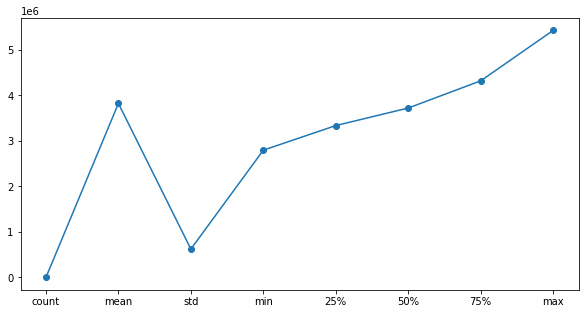

In [15]:
ax=df.describe().T.loc['Sale Quantity',:].plot(figsize=(10,5), marker='o')

In [0]:
#Drop Month,Promotion Expenses,Competition Promotion columns as it is not used for prediction.The time column is only a primary key
df.drop(["Month", "Promotion Expenses", "Competition Promotion"], axis=1, inplace=True)

In [17]:
df.shape

(48, 1)

In [0]:
#Normalize the data
#Use MinMax Scaler to scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

In [0]:
#we can get original data from scaled data using inverse_transform
#scaled.inverse_transform(scaler)

### Split Data

In [20]:
#70% examples will used for training (in the begining)
train_size = int(len(scaled) * 0.70)

#30% will be used for Test
#test_size = len(scaled - train_size)
test_size = len(scaled) - train_size

print("Train size and Test size are : ",train_size, test_size, len(scaled))

Train size and Test size are :  33 15 48


In [21]:
#Split the data
train = scaled[0:train_size, :]
test = scaled[train_size: len(scaled), :]
print('train Size : {}\ntest Size: {}'.format(len(train), len(test)))
print('train Shape : {}\ntest Shape: {}'.format(train.shape, test.shape))
print('\ntrain :\n {}\n\ntest : {}'.format(train[0:2], test[0:2]))

train Size : 33
test Size: 15
train Shape : (33, 1)
test Shape: (15, 1)

train :
 [[0.07759176]
 [0.60881978]]

test : [[0.33833604]
 [0.35328606]]


### Build Input and Output data
for both Training and Test based on the window or past history size

In [0]:
#window - how long the sequence will be or how many time steps to predict
#function to create X_train, y_train and X_test, y_test
def create_dataset(dataset, window=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-window):
        #print(i, i+window)

        #X_train
        a = dataset[i:(i+window), 0]

        #y_train
        b = dataset[i+window, 0]

        #print(a, b)
        dataX.append(a)
        dataY.append(b)
    
    return np.array(dataX), np.array(dataY)

In [0]:
#Create Input and Output
window_size =1
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)

In [24]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(32, 1) (32,)
(14, 1) (14,)


In [25]:
X_train[0:5]

array([[0.07759176],
       [0.60881978],
       [0.15453414],
       [0.54950124],
       [0.07731606]])

In [26]:
#The second datapoint of X_train, will be first datapoint of y_train
y_train[0:5]

array([0.60881978, 0.15453414, 0.54950124, 0.07731606, 0.59978666])

###Compare multiple classical regression 
#####Classical machine learning Algorithms : LR, KNN, SVR, DT (CART), RF
- Linear regression
- K-nearest neighbors regression
- Support vector machines regression
- Decision trees regression
- Random Forest regression

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [0]:
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVM', SVR()))
models.append(('CART1', DecisionTreeRegressor(max_depth=10)))
models.append(('CART2', DecisionTreeRegressor(max_depth=4)))
models.append(('RF', RandomForestRegressor()))

In [29]:
# Model Performance of each model
# evaluate each model in turn
results = []
names = []
for name, model in models:
    model = model.fit(X_train, y_train)
    msg = "%s: %f (%f) " % (name, model.score(X_train, y_train), model.score(X_test, y_test))
    print("Model name: Train-score(Test-score)")
    print(msg)

Model name: Train-score(Test-score)
LR: 0.214627 (-1.306389) 
Model name: Train-score(Test-score)
KNN: 0.567962 (-1.147035) 
Model name: Train-score(Test-score)
SVM: 0.434129 (-0.779541) 
Model name: Train-score(Test-score)
CART1: 0.997646 (-0.974469) 
Model name: Train-score(Test-score)
CART2: 0.808472 (-1.044525) 
Model name: Train-score(Test-score)
RF: 0.887950 (-0.930210) 


#### Observations:
- In this case LR model is an overfit model, with 90% Train R2 and 58%
- All the remaining models are performing very poorly with a negative Test R2, and can be discarded 

In [30]:
## Let us consider Linear regression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
## Let us consider DecisionTree regression
#model = DecisionTreeRegressor()
#model.fit(X_train, y_train)

In [0]:
#Predit values on X_train and X_test
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

#Reshape  trainPredict
trainPredict = trainPredict.reshape(-1,1)

#Un-normalize the predited data in trainPredict
trainPredict = scaler.inverse_transform(trainPredict)

#Reshape  testPredict
testPredict = testPredict.reshape(-1,1)

#Un-normalize the predited data in testPredict
testPredict = scaler.inverse_transform(testPredict)

In [33]:
trainPredict.shape

(32, 1)

In [34]:
testPredict.shape

(14, 1)

In [35]:
#shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict

#shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict

print(trainPredictPlot.shape, testPredictPlot.shape)
print(trainPredictPlot[0:3])
print(testPredictPlot[45:])

(48, 1) (48, 1)
[[             nan]
 [3991724.16457581]
 [3359403.73048189]]
[[3015578.05081464]
 [3257417.89058059]
 [3258878.8088985 ]]


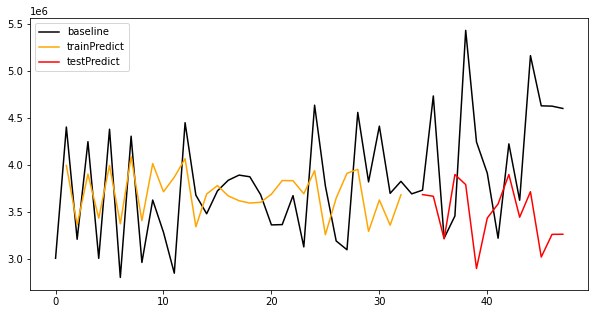

In [36]:
# plot baseline, trainPredict and testPredict
plt.figure(figsize=(10,5))
labels = ['baseline', 'trainPredict', 'testPredict']

#baseline plot
plt.plot(scaler.inverse_transform(scaled), color='black')

#Train Predicted Plot
plt.plot(trainPredictPlot, color='orange')

#Test Predicted Plot
plt.plot(testPredictPlot, color='red')

plt.legend(labels)
plt.show()

### Observations:
- Black plot is original data, orange is trainpredicted and red is testPredicted
- Both orange and red are far away from black plot.There is a deviation of orange and red plots from black
- The train and test Predictions are far away from baseline predictions, so we can say the model is not performing well on train and test dataset
- This is the reason Linear Regression is performing very badly on the data and it is clear/evident from this plot
- We can increase this model furthur by using LSTM

#### The LSTM network expects the input data (X) to be provided with a specific array structure in the form of : [samples, time steps, features]

In [37]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(32, 1) (32,)
(14, 1) (14,)


In [38]:
print(X_train.shape[0], X_train.shape[1], 1)
print(X_test.shape[0], X_test.shape[1], 1)

32 1 1
14 1 1


In [39]:
#Make it 3 Dimensional Data - needed for LSTM
#dim1: No of rows
#dim2: No of months into the past which we use to predict the present(past history)
#dim3: No of features
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(32, 1, 1)
(14, 1, 1)


### Build the Model

In [0]:
#Clear the session before adding a model
tf.keras.backend.clear_session()

#Add a Sequential container
model = tf.keras.Sequential()

#Add the LSTM layer with some Memory Units.
model.add(tf.keras.layers.LSTM(8, input_shape=(window_size, 1)))

#Add Ddense layer
model.add(tf.keras.layers.Dense(1))

#For compiing the model, use adam as the optimizer and since it is a regression problem, we use mse as the loss 
adam_optimizer = tf.keras.optimizers.Adam(lr=0.3)
#sgd_optimizer = tf.keras.optimizers.SGD( lr=0.05)
model.compile(optimizer=adam_optimizer, loss='mse')

In [0]:
#Add model checkpoint to save the best model weights.The best model is one with least validation loss
LSTMcheckpoint_path = "/content/drive/My Drive/AIML/SequentialModels/savedModels/lstm.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=LSTMcheckpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode = 'min',
                                                 save_best_only=True,
                                                 verbose=1)

In [59]:
#Run the model for 2000 epochs , with batch size of 32, save weights of best model using callbacks
model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), batch_size=32, callbacks=[cp_callback])

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 0.1635
Epoch 00001: val_loss improved from inf to 0.08524, saving model to /content/drive/My Drive/AIML/SequentialModels/savedModels/lstm.ckpt
1/1 [==============================] - 0s 364ms/step - loss: 0.1635 - val_loss: 0.0852
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 0.1228
Epoch 00002: val_loss did not improve from 0.08524
1/1 [==============================] - 0s 33ms/step - loss: 0.1228 - val_loss: 0.0923
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 0.0443
Epoch 00003: val_loss did not improve from 0.08524
1/1 [==============================] - 0s 29ms/step - loss: 0.0443 - val_loss: 0.2246
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 0.0809
Epoch 00004: val_loss did not improve from 0.08524
1/1 [==============================] - 0s 30ms/step - loss: 0.0809 - val_loss: 0.1316
Epoch 5/1000
1/1 [==============================] - ETA: 0s - loss

### Load saved weights

In [60]:
# Loads the weights
model.load_weights(LSTMcheckpoint_path)

### Model evaluation

In [61]:
#Train loss (trainMSE)
train_loss_and_metrics = model.evaluate(X_train, y_train)
print(train_loss_and_metrics)

#Test loss (testMSE)
test_loss_and_metrics = model.evaluate(X_test, y_test)
print(test_loss_and_metrics)

1/1 [==============================] - 0s 1ms/step - loss: 0.0660
0.06595338135957718
1/1 [==============================] - 0s 825us/step - loss: 0.0666
0.06662965565919876


### Model Prediction
### Get Predictions for both Training and Test Data

In [0]:
#Get prediction for both Training and Test Data
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [63]:
print(X_train.shape, y_train.shape, trainPredict.shape)

(32, 1, 1) (32,) (32, 1)


In [64]:
print(X_test.shape, y_test.shape, testPredict.shape)

(14, 1, 1) (14,) (14, 1)


In [65]:
print(X_train[0],y_train[0], trainPredict[0])
print(X_test[0],y_test[0], testPredict[0])

[[0.07759176]] 0.6088197810510583 [0.49941263]
[[0.33833604]] 0.3532860569291554 [0.5024062]


### Model Performance
### Train and Test  R2 and RMSE

In [66]:
#Train R2 and Test R2
print("Train R2 (Accuracy) is ",r2_score(y_train, trainPredict))
print("Test R2 (Accuracy) is ",r2_score(y_test, testPredict))

Train R2 (Accuracy) is  -0.6904548309663394
Test R2 (Accuracy) is  -0.013169244146283399


In [67]:
#Train MSE and Test MSE
print("Train mse (loss) is ",mean_squared_error(y_train, trainPredict))
print("Test mse (loss) is ",mean_squared_error(y_test, testPredict))

Train mse (loss) is  0.06595338541359039
Test mse (loss) is  0.06662965210867118


In [68]:
#Train RMSE and Test RMSE
print("Train rmse (loss) is ",np.sqrt(mean_squared_error(y_train, trainPredict)))
print("Test rmse (loss) is ",np.sqrt(mean_squared_error(y_test, testPredict)))

Train rmse (loss) is  0.2568139120327993
Test rmse (loss) is  0.2581272014117675


In [0]:
#Un-normalize the predited data
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

### Plot to visualize Baseline, Train Predictions and Test Predictions

In [69]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict

print(trainPredictPlot.shape, testPredictPlot.shape)
print(trainPredictPlot[0:3], trainPredictPlot[98:101])
print(testPredictPlot[100:103], testPredictPlot[141:])

(48, 1) (48, 1)
[[       nan]
 [0.49941263]
 [0.50504303]] []
[] []


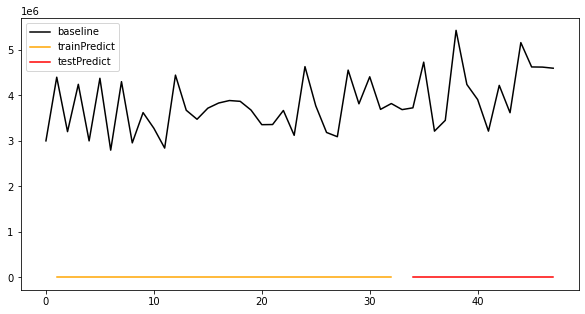

In [70]:
# plot baseline, trainPredict and testPredict
plt.figure(figsize=(10,5))
labels = ['baseline', 'trainPredict', 'testPredict']

#baseline plot
plt.plot(scaler.inverse_transform(scaled), color='black')

#Train Predicted Plot
plt.plot(trainPredictPlot, color='orange')

#Test Predicted Plot
plt.plot(testPredictPlot, color='red')

plt.legend(labels)
plt.show()

#### Observations:
- **The plot shows that LSTM model is not performing well on the dataset**